In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [ ]:
# Example of nn model

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self._input = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
        )
        self._fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self._fc_var   = nn.Linear (hidden_dim, latent_dim)

    def forward(self, x):
        output_  = self._input(x)
        mean_    = self._fc_mean(output_)
        log_var_ = self._fc_var(output_)
        return mean_, log_var_

# Model Hyperparameters
dataset_path = '~/datasets'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 100
x_dim  = 784
hidden_dim = 400
latent_dim = 200
lr = 1e-3
epochs = 30

model = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

In [8]:
# torchviz code for extracting model structure

In [7]:
from collections import namedtuple
from distutils.version import LooseVersion
from graphviz import Digraph
import torch
from torch.autograd import Variable
import warnings

Node = namedtuple('Node', ('name', 'inputs', 'attr', 'op'))

# Saved attrs for grad_fn (incl. saved variables) begin with `._saved_*`
SAVED_PREFIX = "_saved_"

def get_fn_name(fn, show_attrs, max_attr_chars):
    name = str(type(fn).__name__)
    if not show_attrs:
        return name
    attrs = dict()
    for attr in dir(fn):
        if not attr.startswith(SAVED_PREFIX):
            continue
        val = getattr(fn, attr)
        attr = attr[len(SAVED_PREFIX):]
        if torch.is_tensor(val):
            attrs[attr] = "[saved tensor]"
        elif isinstance(val, tuple) and any(torch.is_tensor(t) for t in val):
            attrs[attr] = "[saved tensors]"
        else:
            attrs[attr] = str(val)
    if not attrs:
        return name
    max_attr_chars = max(max_attr_chars, 3)
    col1width = max(len(k) for k in attrs.keys())
    col2width = min(max(len(str(v)) for v in attrs.values()), max_attr_chars)
    sep = "-" * max(col1width + col2width + 2, len(name))
    attrstr = '%-' + str(col1width) + 's: %' + str(col2width)+ 's'
    truncate = lambda s: s[:col2width - 3] + "..." if len(s) > col2width else s
    params = '\n'.join(attrstr % (k, truncate(str(v))) for (k, v) in attrs.items())
    return name + '\n' + sep + '\n' + params

def make_dot_from_trace(trace):
    """ This functionality is not available in pytorch core at
    https://pytorch.org/docs/stable/tensorboard.html
    """
    # from tensorboardX
    raise NotImplementedError("This function has been moved to pytorch core and "
                              "can be found here: https://pytorch.org/docs/stable/tensorboard.html")


def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.

    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)

def my_make_dot(var, params=None, show_attrs=False, show_saved=False, max_attr_chars=50):
    """ Produces Graphviz representation of PyTorch autograd graph.

    If a node represents a backward function, it is gray. Otherwise, the node
    represents a tensor and is either blue, orange, or green:
     - Blue: reachable leaf tensors that requires grad (tensors whose .grad
         fields will be populated during .backward())
     - Orange: saved tensors of custom autograd functions as well as those
         saved by built-in backward nodes
     - Green: tensor passed in as outputs
     - Dark green: if any output is a view, we represent its base tensor with
         a dark green node.

    Args:
        var: output tensor
        params: dict of (name, tensor) to add names to node that requires grad
        show_attrs: whether to display non-tensor attributes of backward nodes
            (Requires PyTorch version >= 1.9)
        show_saved: whether to display saved tensor nodes that are not by custom
            autograd functions. Saved tensor nodes for custom functions, if
            present, are always displayed. (Requires PyTorch version >= 1.9)
        max_attr_chars: if show_attrs is True, sets max number of characters
            to display for any given attribute.
    """

    if params is not None:
        assert all(isinstance(p, Variable) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}
    else:
        param_map = {}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='10',
                     ranksep='0.1',
                     height='0.2',
                     fontname='monospace')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    def get_var_name(var, name=None):
        if not name:
            name = param_map[id(var)] if id(var) in param_map else ''
        return '%s\n %s' % (name, size_to_str(var.size()))

    def add_nodes(fn):
        assert not torch.is_tensor(fn)
        if fn in seen:
            return
        seen.add(fn)

        if show_saved:
            for attr in dir(fn):
                if not attr.startswith(SAVED_PREFIX):
                    continue
                val = getattr(fn, attr)
                seen.add(val)
                attr = attr[len(SAVED_PREFIX):]
                if torch.is_tensor(val):
                    dot.edge(str(id(fn)), str(id(val)), dir="none")
                    dot.node(str(id(val)), get_var_name(val, attr), fillcolor='orange')
                if isinstance(val, tuple):
                    for i, t in enumerate(val):
                        if torch.is_tensor(t):
                            name = attr + '[%s]' % str(i)
                            dot.edge(str(id(fn)), str(id(t)), dir="none")
                            dot.node(str(id(t)), get_var_name(t, name), fillcolor='orange')

        if hasattr(fn, 'variable'):
            # if grad_accumulator, add the node for .variable
            var = fn.variable
            seen.add(var)
            dot.node(str(id(var)), get_var_name(var), fillcolor='lightblue')
            dot.edge(str(id(var)), str(id(fn)))

        # add the node for this grad_fn
        dot.node(str(id(fn)), get_fn_name(fn, show_attrs, max_attr_chars))

        # recurse
        if hasattr(fn, 'next_functions'):
            for u in fn.next_functions:
                if u[0] is not None:
                    dot.edge(str(id(u[0])), str(id(fn)))
                    add_nodes(u[0])

# note: this used to show .saved_tensors in pytorch0.2, but stopped
        # working* as it was moved to ATen and Variable-Tensor merged
        # also note that this still works for custom autograd functions
        if hasattr(fn, 'saved_tensors'):
            for t in fn.saved_tensors:
                seen.add(t)
                dot.edge(str(id(t)), str(id(fn)), dir="none")
                dot.node(str(id(t)), get_var_name(t), fillcolor='orange')


    def add_base_tensor(var, color='darkolivegreen1'):
        if var in seen:
            return
        seen.add(var)
        dot.node(str(id(var)), get_var_name(var), fillcolor=color)
        if (var.grad_fn):
            add_nodes(var.grad_fn)
            dot.edge(str(id(var.grad_fn)), str(id(var)))
        if var._is_view():
            add_base_tensor(var._base, color='darkolivegreen3')
            dot.edge(str(id(var._base)), str(id(var)), style="dotted")


    # handle multiple outputs
    if isinstance(var, tuple):
        for v in var:
            add_base_tensor(v)
    else:
        add_base_tensor(var)

    resize_graph(dot)

    return dot

In [17]:
import torch
from torch.autograd import Variable

def my_make_json(var, params=None, show_attrs=False, show_saved=False, max_attr_chars=50):
    """Преобразует граф вычислений PyTorch в JSON-совместимый словарь."""

    if params is not None:
        assert all(isinstance(p, Variable) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}
    else:
        param_map = {}

    graph_data = {"nodes": [], "edges": []}
    seen = set()

    def size_to_str(size):
        return '(' + (', ').join(['%d' % v for v in size]) + ')'

    def get_var_name(var, name=None):
        if not name:
            name = param_map[id(var)] if id(var) in param_map else ''
        return f'{name} {size_to_str(var.size())}'

    def get_fn_name(fn):
        """Возвращает имя функции в графе"""
        return str(type(fn).__name__)

    def add_nodes(fn):
        """Рекурсивно добавляет узлы в словарь"""
        if fn in seen:
            return
        seen.add(fn)

        # Добавляем текущий узел
        graph_data["nodes"].append({
            "id": id(fn),
            "type": "Function",
            "name": get_fn_name(fn)
        })

        # Добавляем связи
        if hasattr(fn, 'next_functions'):
            for u in fn.next_functions:
                if u[0] is not None:
                    graph_data["edges"].append({"from": id(u[0]), "to": id(fn)})
                    add_nodes(u[0])

        # Обрабатываем сохраненные тензоры
        if show_saved and hasattr(fn, 'saved_tensors'):
            for t in fn.saved_tensors:
                if t not in seen:
                    seen.add(t)
                    graph_data["nodes"].append({
                        "id": id(t),
                        "type": "Tensor",
                        "name": get_var_name(t),
                        "color": "orange"
                    })
                    graph_data["edges"].append({"from": id(t), "to": id(fn)})

    def add_base_tensor(var, color='lightblue'):
        """Добавляет начальный тензор в граф"""
        if var in seen:
            return
        seen.add(var)

        graph_data["nodes"].append({
            "id": id(var),
            "type": "Tensor",
            "name": get_var_name(var),
            "color": color
        })

        if var.grad_fn:
            add_nodes(var.grad_fn)
            graph_data["edges"].append({"from": id(var.grad_fn), "to": id(var)})

        if var._is_view():
            add_base_tensor(var._base, color='darkolivegreen3')
            graph_data["edges"].append({"from": id(var._base), "to": id(var), "style": "dotted"})

    # Обрабатываем входной тензор (или кортеж)
    if isinstance(var, tuple):
        for v in var:
            add_base_tensor(v)
    else:
        add_base_tensor(var)

    return graph_data

# Пример использования
x = torch.randn(1, 10, requires_grad=True)
y = torch.randn(10, 5, requires_grad=True)
z = torch.matmul(x, y)  # Пример вычисления



In [18]:
enc = Encoder(10, 12, 4)
x = np.random.normal(1, size=10)
t = torch.tensor(x, dtype=torch.float32).reshape(1, 10)
out = enc(t)
my_make_dot(out, params=dict(enc.named_parameters())).render("my_model_graph", format="png")

graph_dict = my_make_json(z)

import json
print(json.dumps(graph_dict, indent=2))  # Вывод в формате JSON

{
  "nodes": [
    {
      "id": 133701896272784,
      "type": "Tensor",
      "name": " (1, 5)",
      "color": "lightblue"
    },
    {
      "id": 133702047040608,
      "type": "Function",
      "name": "MmBackward0"
    },
    {
      "id": 133702047045168,
      "type": "Function",
      "name": "AccumulateGrad"
    },
    {
      "id": 133702047042816,
      "type": "Function",
      "name": "AccumulateGrad"
    }
  ],
  "edges": [
    {
      "from": 133702047045168,
      "to": 133702047040608
    },
    {
      "from": 133702047042816,
      "to": 133702047040608
    },
    {
      "from": 133702047040608,
      "to": 133701896272784
    }
  ]
}


In [13]:
# extracting weight and bias

In [20]:
def get_layer(model, path):
    parts = path.split(".")
    layer = model
    for part in parts:
        if part.isdigit():
            part = int(part)
            layer =layer[part]
        else:
          layer = getattr(layer, part)
    return layer

In [21]:
def get_weight(model, path):
  layer = get_layer(model, path)
  return layer.state_dict()['weight']

def get_bias(model, path):
  layer = get_layer(model, path)
  return layer.state_dict()['bias']

In [22]:
get_weight(model, '_input.0')

tensor([[ 0.0272,  0.0201, -0.0155,  ..., -0.0011, -0.0295,  0.0244],
        [-0.0219,  0.0068, -0.0195,  ..., -0.0135, -0.0032, -0.0219],
        [ 0.0121,  0.0173, -0.0285,  ..., -0.0311,  0.0163, -0.0347],
        ...,
        [ 0.0207, -0.0115, -0.0011,  ..., -0.0333, -0.0096,  0.0034],
        [-0.0289,  0.0167, -0.0317,  ..., -0.0135,  0.0310, -0.0085],
        [ 0.0357,  0.0221,  0.0320,  ..., -0.0097, -0.0074, -0.0180]])

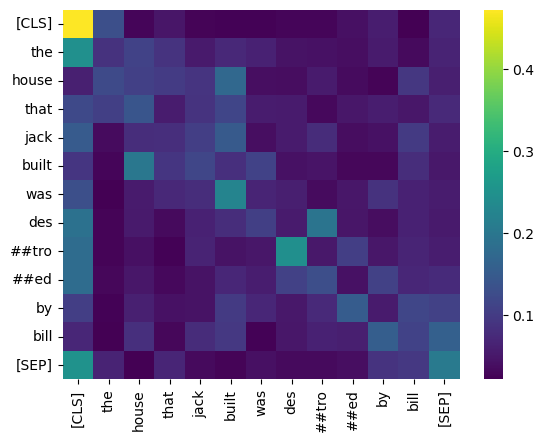

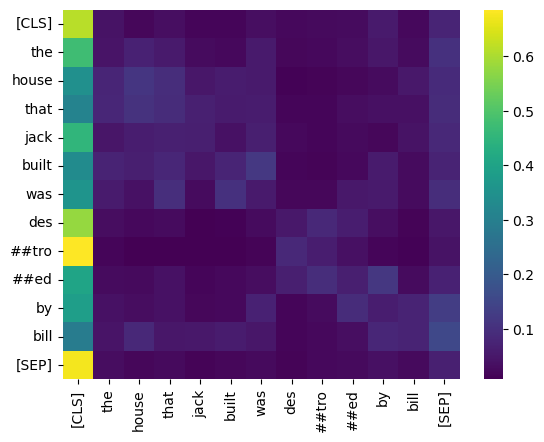

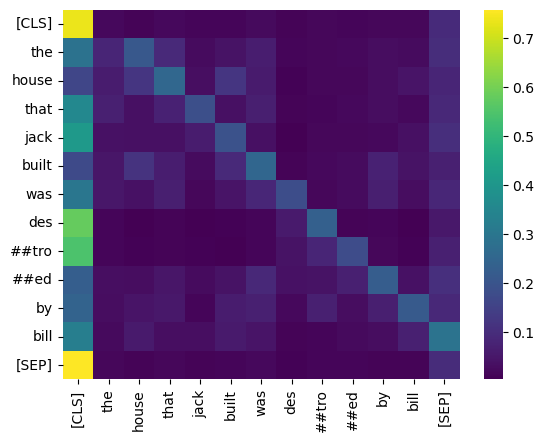

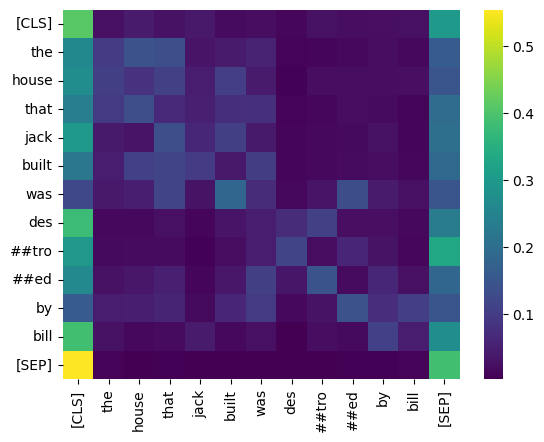

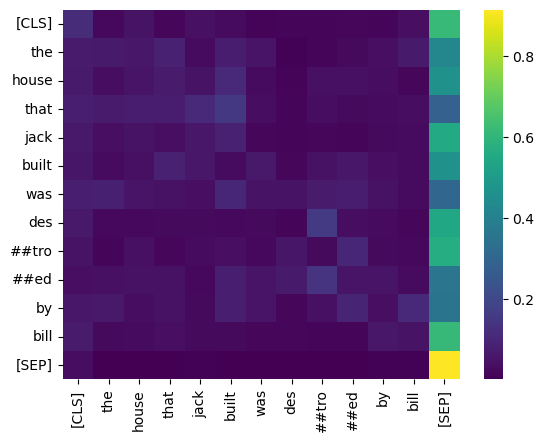

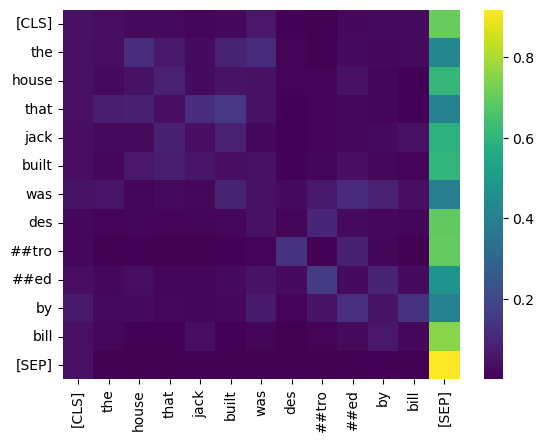

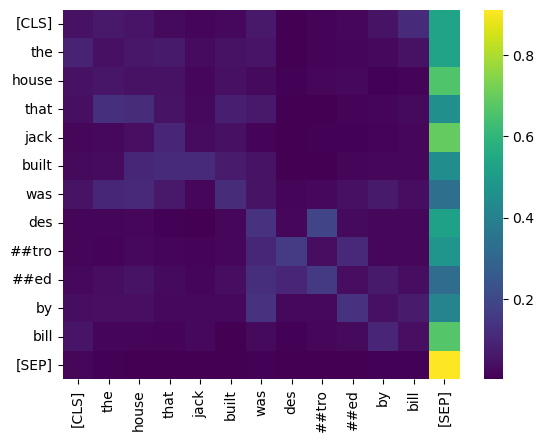

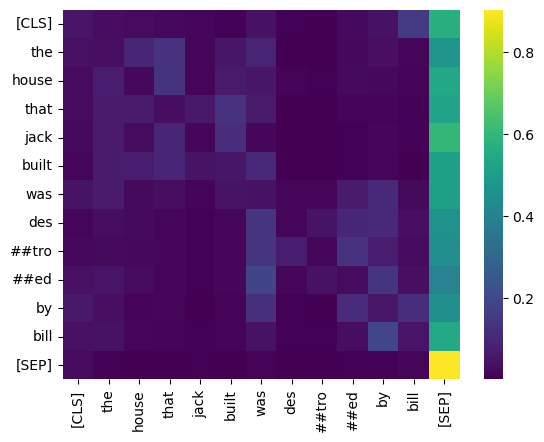

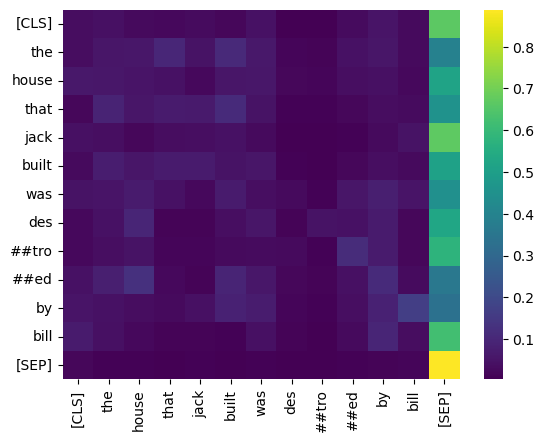

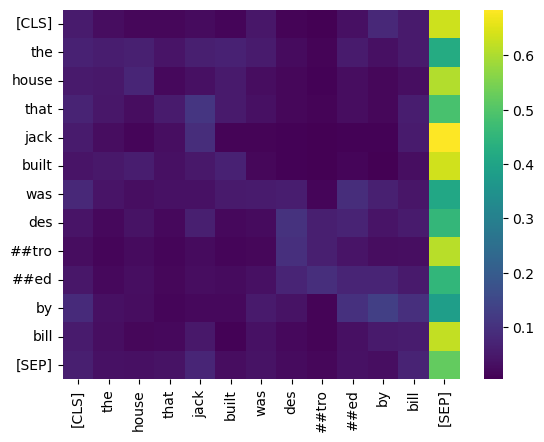

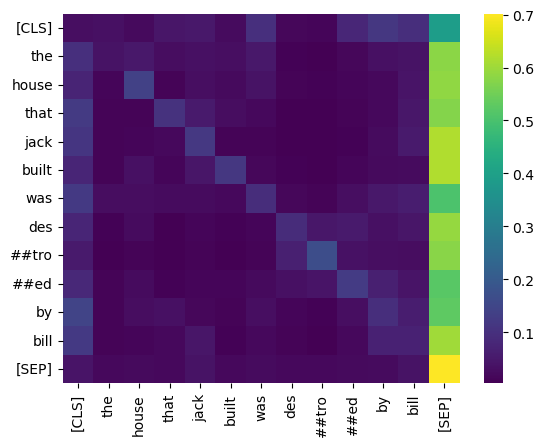

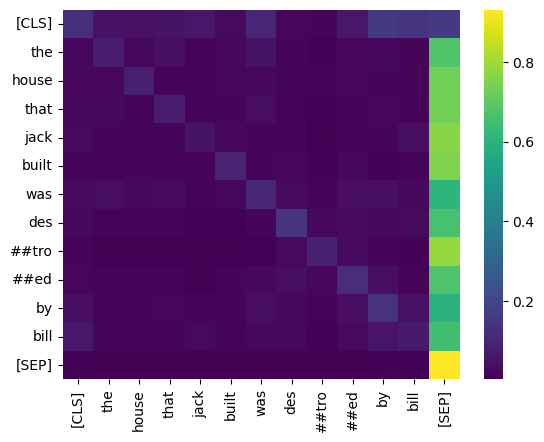

In [11]:
from transformers import BertModel
import matplotlib.pyplot as plt
from tcv import tcv

model = BertModel.from_pretrained("bert-base-uncased", output_attentions=True)

for layer in range(12):
    tcv.attention_matrix(model, layer=layer, text="The house that Jack built was destroed by Bill")
    plt.show()